In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image

In [2]:
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12

In [3]:
C = cosmology.FlatLambdaCDM(70.0, 0.3)

In [4]:
states = pd.Index(('BD', 'RD', 'RE'))

In [5]:
rate_labels = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=[['$r_{BD \rightarrow BD}$', '$r_{RD \rightarrow BD}$', '$r_{RE \rightarrow BD}$'],
                           ['$r_{BD \rightarrow RD}$', '$r_{RD \rightarrow RD}$', '$r_{RE \rightarrow RD}$'],
                           ['$r_{BD \rightarrow RE}$', '$r_{RD \rightarrow RE}$', '$r_{RE \rightarrow RE}$']])
rate_labels

,from BD,from RD,from RE
to BD,$r_{BD \rightarrow BD}$,$r_{RD \rightarrow BD}$,$r_{RE \rightarrow BD}$
to RD,$r_{BD \rightarrow RD}$,$r_{RD \rightarrow RD}$,$r_{RE \rightarrow RD}$
to RE,$r_{BD \rightarrow RE}$,$r_{RD \rightarrow RE}$,$r_{RE \rightarrow RE}$


$\frac{dN_{BD}}{dt} = - N_{BD} \, (r_{BD \rightarrow RD} + r_{BD \rightarrow RE})$

$\frac{dN_{RD}}{dt} = - N_{RD} \, r_{RD \rightarrow RE} + N_{BD} \, r_{BD \rightarrow RD}$

$\frac{dN_{RE}}{dt} = + N_{BD} \, r_{BD \rightarrow RE} + N_{RD} \, r_{RD \rightarrow RE}$

In [6]:
# Set rates per galaxy in Gyr^{-1} at fiducial redshift
rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((3, 3)))
rates['from BD']['to RD'] = 0.05
rates['from RD']['to RE'] = 0.05
rates['from BD']['to RE'] = 0.01
for s in states:
    rates['from ' + s]['to ' + s] = 0
    rates['from ' + s]['to ' + s] = - rates['from ' + s].sum()
rates

,from BD,from RD,from RE
to BD,-0.06,0.00,0
to RD,0.05,-0.05,0
to RE,0.01,0.05,-0


In [7]:
# Modelling rates as linear function of cosmic time
#(for simplicity, should probably choose someting more appropriate)
rates_evol = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((3, 3)))
rates_evol['from BD']['to RD'] = 0.01  # comment out this to have no evolution!

In [8]:
def rates_function(rates, rates_evol, t, t0):
    rates = rates + rates_evol * (t - t0)
    for s in states:
        rates['from ' + s]['to ' + s] = 0
        rates['from ' + s]['to ' + s] = - rates['from ' + s].sum()
    return rates

In [9]:
# test it out...
rates_function(rates, rates_evol, t=C.age(0.3).value, t0=C.age(1.0).value)

,from BD,from RD,from RE
to BD,-0.102965,0.00,0
to RD,0.092965,-0.05,0
to RE,0.010000,0.05,-0


In [10]:
def model(N, t, ratefn, rates, rates_evol, t0):
    rates = ratefn(rates, rates_evol, t, t0)
    return np.dot(rates, N)

In [11]:
# initial relative number densities
# for log(M*/Msun) ~ 10.5, starting with f_{R|D} ~ 0.05 and f_{D|R} ~ 0.1 at z ~ 1
N0 = pd.Series(index=states, data=[0.6, 0.03, 0.3])
N0 /= N0.sum()  # normalise to unity
N0

BD    0.645161
RD    0.032258
RE    0.322581
dtype: float64

In [12]:
# redshifts and times to evaluate
zstart = 1.0
zend = 0.3
z = np.linspace(zstart, zend, 100)
t = C.age(z)
t0 = C.age(zend).value

In [13]:
N = odeint(model, N0, t, args=(rates_function, rates, rates_evol, t0))

In [14]:
N = pd.DataFrame(index=z, columns='$N_{' + states + '}$', data=N)
N = N[::-1]

In [15]:
F = pd.DataFrame(index=N.index)
F['$f_{R|D}$'] = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{BD}$'])
F['$f_{D|R}$'] = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{RE}$'])

In [16]:
def plot_NF(N, F):
    fig, (axN, axF) = plt.subplots(1, 2, figsize=(12, 6))
    N.plot(ax=axN)
    axN.set(xlabel='$z$', ylabel='$N(z)/N(z={:.1f})$'.format(zstart), ylim=(0, 1));
    F.plot(ax=axF)
    axF.set(xlabel='$z$', ylabel='$f(z)$', ylim=(0, 0.4));
    plt.tight_layout()

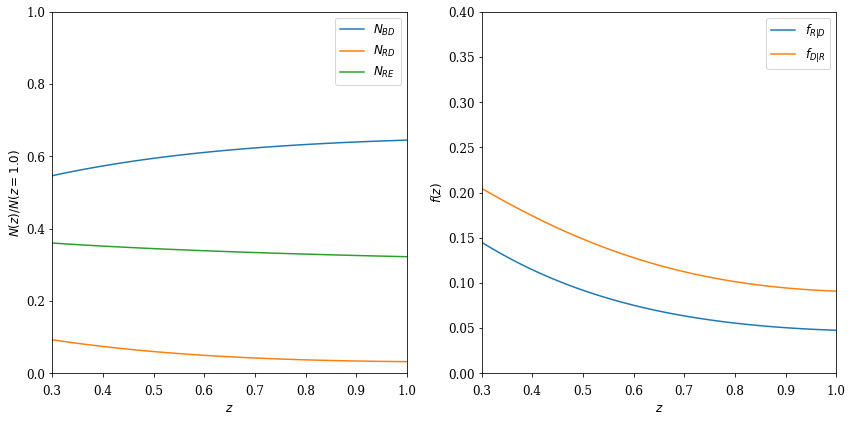

In [17]:
plot_NF(N, F)

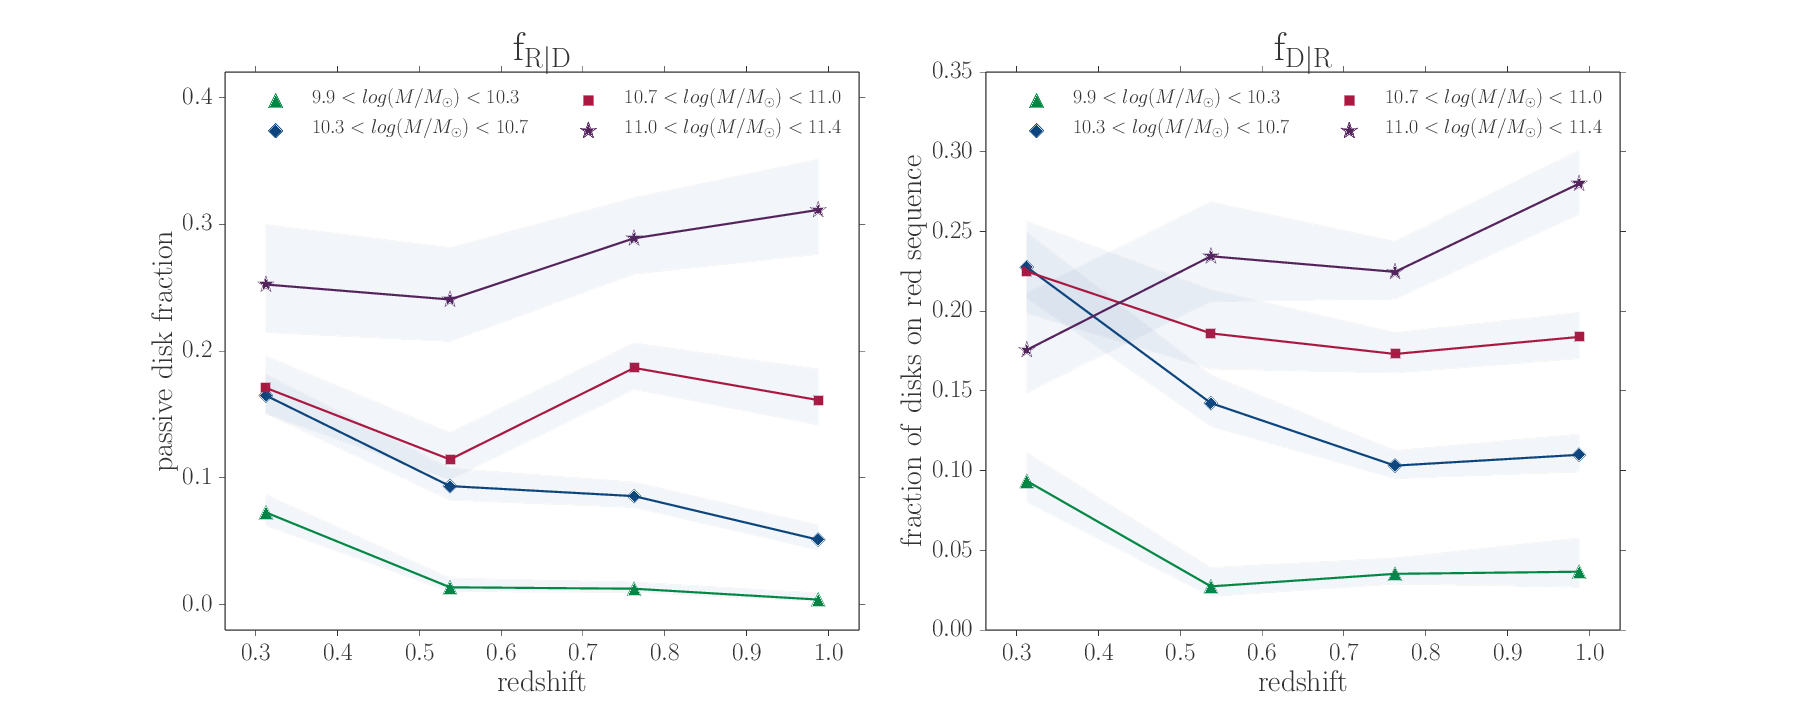

In [18]:
Image('red_disk_fraction.png')